In [4]:
import models
import utils
import data_processing
from constants import (
    VALUE_COLUMN,
    UNIT_RATE_COLUMN,
    QUANTITY_COLUMN,
    GROSS_WEIGHT_COLUMN,
    SHIP_COUNT_COLUMN,
    PORT_COUNT_COLUMN,
    FILL_METHOD,
    TARGET_COLUMN,
    VOLZA_COLUMNS,
    AIS_COLUMNS,
    OIL_COLUMNS,
    ARIMA_RESIDUAL_COLUMN,
    RANDOM_STATE
)
import pandas as pd
import constants
import sys
from datetime import datetime
from build_data import get_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

import matplotlib.pyplot as plt
import numpy as np

In [5]:
COMMODITYS = ['cobalt', 'copper', 'germanium', 'magnesium', 'nickel']
target_COMMODITY = "nickel"
WINDOW_SIZE = 20

In [6]:
pre_features = []
pre_labels = []
tar_features = []
tar_labels = []
# for COMMODITY in COMMODITYS:
COMMODITY = target_COMMODITY

VOLZA_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}.csv"
PRICE_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}_prices.csv"

# Get the data
data = get_data(VOLZA_FILE_PATH, PRICE_FILE_PATH, window_size=WINDOW_SIZE, center=False)

# Add Isolation Forest spikes column
data['spikes_if'] = utils.detect_spikes_if(data, TARGET_COLUMN + VOLZA_COLUMNS, contamination=0.1)

data['spikes_streaming'] = utils.detect_spikes_streaming(data, 'Price', window_size=WINDOW_SIZE)

# Add Bowen's spike detection
spikes, features, labels = utils.detect_spikes_new(data, TARGET_COLUMN, window_size=WINDOW_SIZE, center=False)
if COMMODITY == target_COMMODITY:
    tar_features.extend(features)
    tar_labels.extend(labels)
    #     continue
    # pre_features.extend(features)
    # pre_labels.extend(labels)

data.head(2)

Building data...


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={"Value": "Brent Oil Value"}, inplace=True)
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={"Value": "WTI Oil Value"}, inplace=True)
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inste

Rows dropped due to NaN values: 1
Detecting spikes... 20


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),Price,Brent Oil Value,WTI Oil Value,ARIMA_Residuals,spikes,spikes_if,spikes_streaming
1,2020-01-02,11448.27,2221.0,221.0,6.162114,14260.0,67.05,61.17,14260.000000,0,0,0
2,2020-01-03,9212.00,2000.0,2060.0,4.606000,13755.0,69.08,63.00,974.508279,0,0,0


Spike Percentage: 17.04%


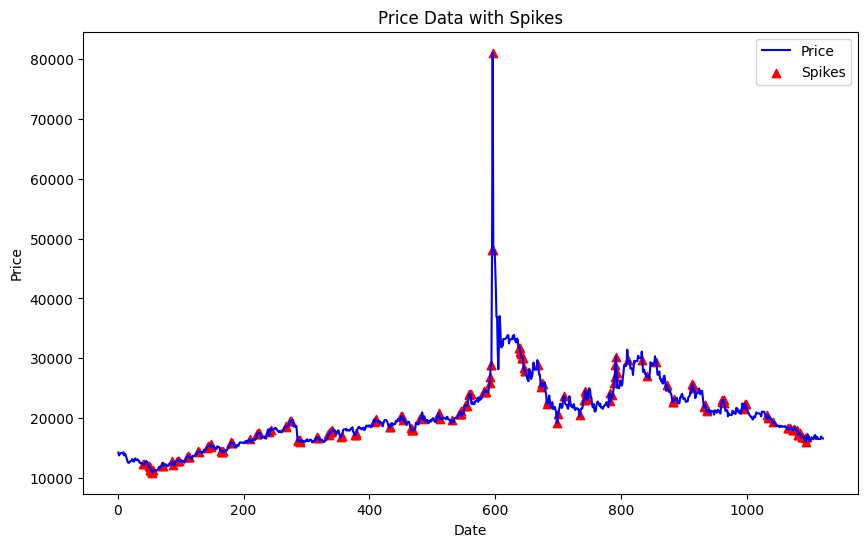

In [7]:
padded_spikes = np.pad(spikes, (data.shape[0] - len(spikes), 0), 'constant', constant_values=(0,))
data['spikes_new'] = padded_spikes
utils.plot_prices(data,column='spikes_new')

In [8]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomOverSampler
output_file_path = f'{target_COMMODITY}_test/test/results_test.csv'
pred_file_path = f'{target_COMMODITY}_test/test/predictions/test'
model_path = f'{target_COMMODITY}_test/best_model'

In [9]:
data

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),Price,Brent Oil Value,WTI Oil Value,ARIMA_Residuals,spikes,spikes_if,spikes_streaming,spikes_new
1,2020-01-02,11448.270000,2221.0,221.000,6.162114,14260.0,67.05,61.17,14260.000000,0,0,0,0
2,2020-01-03,9212.000000,2000.0,2060.000,4.606000,13755.0,69.08,63.00,974.508279,0,0,0,0
3,2020-01-07,35357.780069,10021.0,3154.118,4.299307,13935.0,68.74,62.70,2632.758819,0,0,0,0
4,2020-01-08,316028.429958,78042.0,0.000,4.224362,14050.0,67.31,59.65,624.487921,0,0,0,0
5,2020-01-10,764.550000,200.0,0.000,3.822750,14190.0,66.77,59.02,724.194239,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,2023-12-26,70410.000000,15450.0,0.000,4.957500,16509.0,78.89,72.16,-7494.874616,0,0,0,0
1118,2023-12-27,90630.000000,18450.0,0.000,7.100000,16938.0,78.89,72.16,-7065.874616,0,0,0,0
1119,2023-12-28,87003.180000,19610.8,63024.540,62.855326,16734.0,78.89,72.16,-7269.874616,0,0,0,0
1120,2023-12-29,985353.000000,4100.0,0.000,240.330000,16603.0,78.89,72.16,-7400.874616,0,1,0,0


In [10]:
aggregated_df = data
SPIKE_COLUMN = 'spikes_if'

In [11]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

aggregated_df['Price_binned'] = discretizer.fit_transform(aggregated_df[['Price']])
# aggregated_df['AR_binned'] = discretizer.fit_transform(aggregated_df[['ARIMA_Residuals']])
# aggregated_df['Value_binned'] = discretizer.fit_transform(aggregated_df[['Value']])


aggregated_df

c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),Price,Brent Oil Value,WTI Oil Value,ARIMA_Residuals,spikes,spikes_if,spikes_streaming,spikes_new,Price_binned
1,2020-01-02,11448.270000,2221.0,221.000,6.162114,14260.0,67.05,61.17,14260.000000,0,0,0,0,0.0
2,2020-01-03,9212.000000,2000.0,2060.000,4.606000,13755.0,69.08,63.00,974.508279,0,0,0,0,0.0
3,2020-01-07,35357.780069,10021.0,3154.118,4.299307,13935.0,68.74,62.70,2632.758819,0,0,0,0,0.0
4,2020-01-08,316028.429958,78042.0,0.000,4.224362,14050.0,67.31,59.65,624.487921,0,0,0,0,0.0
5,2020-01-10,764.550000,200.0,0.000,3.822750,14190.0,66.77,59.02,724.194239,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,2023-12-26,70410.000000,15450.0,0.000,4.957500,16509.0,78.89,72.16,-7494.874616,0,0,0,0,0.0
1118,2023-12-27,90630.000000,18450.0,0.000,7.100000,16938.0,78.89,72.16,-7065.874616,0,0,0,0,0.0
1119,2023-12-28,87003.180000,19610.8,63024.540,62.855326,16734.0,78.89,72.16,-7269.874616,0,0,0,0,0.0
1120,2023-12-29,985353.000000,4100.0,0.000,240.330000,16603.0,78.89,72.16,-7400.874616,0,1,0,0,0.0


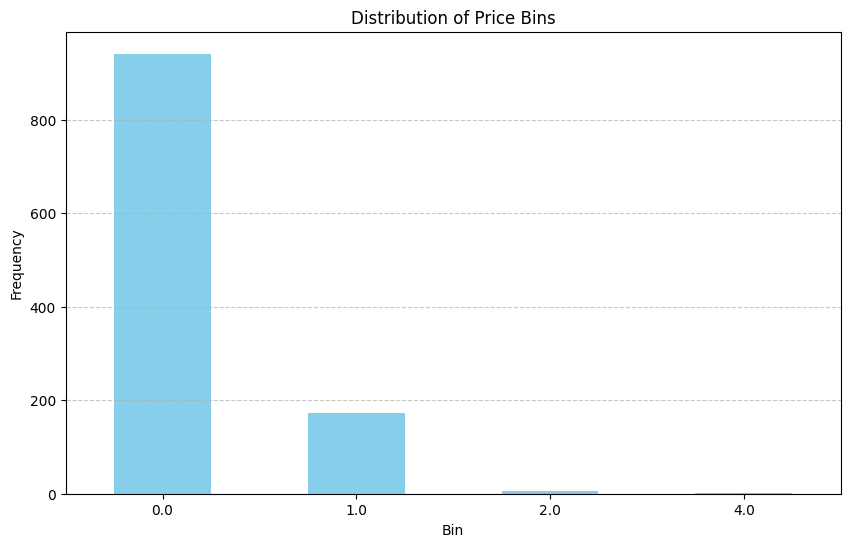

In [12]:
import matplotlib.pyplot as plt

# Assuming 'Price_binned' has been properly added to 'aggregated_df'
# Count the frequency of each bin
bin_counts = aggregated_df['Price_binned'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Price Bins')
plt.xlabel('Bin')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [13]:
# TARGET_COLUMN = ['Price_binned']

In [14]:
# X_price = np.array(tar_features)
# y_price = np.array(tar_labels)
X_price, y_price = data_processing.prepare_features_and_target(data, TARGET_COLUMN, 'spikes_streaming')


# Split price data
# X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_price, y_price, test_size=0.3, random_state=RANDOM_STATE, shuffle=False)
# X_train_price, X_val_price, y_train_price, y_val_price = train_test_split(X_train_price, y_train_price, test_size=(10/70), random_state=RANDOM_STATE, shuffle=False)
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_price, y_price, test_size=0.4, shuffle=False)
X_train_price, y_train_price = RandomOverSampler(random_state=RANDOM_STATE).fit_resample(X_train_price, y_train_price)

# Balancing
X_train_price, y_train_price = sampler(random_state=RANDOM_STATE).fit_resample(X_train_price, y_train_price)

# Scaling
# X_train_price, X_test_price, X_val_price = data_processing.scale_features(X_train_price, X_test_price, X_val_price)
X_train_price, X_test_price = data_processing.scale_features_no_val(X_train_price, X_test_price)

# Sequence making
X_train_price, y_train_price = data_processing.create_sequences(X_train_price, y_train_price, WINDOW_SIZE)
X_test_price, y_test_price = data_processing.create_sequences(X_test_price, y_test_price, WINDOW_SIZE)
#X_val_price, y_val_price = data_processing.create_sequences(X_val_price, y_val_price, WINDOW_SIZE)


# X_train_price = np.expand_dims(X_train_price, axis = 2)
# X_test_price = np.expand_dims(X_test_price, axis = 2)
# X_val_price = np.expand_dims(X_val_price, axis = 2)

In [15]:
# results_df  = models.evaluate_all(X_train_price, y_train_price, X_val_price, y_val_price, X_test_price, y_test_price, output_file_path, pred_file_path, model_path, False, edcra=False, val=True)
results_df  = models.evaluate_all(X_train_price, y_train_price, None, None, X_test_price, y_test_price, output_file_path, pred_file_path, model_path, False, edcra=False, val=False)




14/14 [==============================] - 0s 4ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/LSTM_256_layers_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/LSTM_256_layers_predictions.csv
{'Name': 'LSTM', 'Params': '256 layers', 'Accuracy': 0.09069767441860466, 'Precision (0)': 0.0, 'Recall (0)': 0.0, 'F1 (0)': 0.0, 'Precision (1)': 0.09069767441860466, 'Recall (1)': 1.0, 'F1 (1)': 0.16631130063965888, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

14/14 [==============================] - 0s 3ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/LSTM_128_layers_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/LSTM_128_layers_predictions.csv
{'Name': 'LSTM', 'Params': '128 layers', 'Accuracy': 0.09069767441860466, 'Precision (0)': 0.0, 'Recall (0)': 0.0, 'F1 (0)': 0.0, 'Precision (1)': 0.09069767441860466, 'Recall (1)': 1.0, 'F1 (1)': 0.16631130063965888, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

14/14 [==============================] - 0s 2ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/LSTM_64_layers_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/LSTM_64_layers_predictions.csv
{'Name': 'LSTM', 'Params': '64 layers', 'Accuracy': 0.9209302325581395, 'Precision (0)': 0.9219858156028369, 'Recall (0)': 0.9974424552429667, 'F1 (0)': 0.9582309582309583, 'Precision (1)': 0.8571428571428571, 'Recall (1)': 0.15384615384615385, 'F1 (1)': 0.2608695652173913, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/LSTM_32_layers_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/LSTM_32_layers_predictions.csv
{'Name': 'LSTM', 'Params': '32 layers', 'Accuracy': 0.9162790697674419, 'Precision (0)': 0.9156908665105387, 'Recall (0)': 1.0, 'F1 (0)': 0.9559902200488998, 'Precision (1)': 1.0, 'Recall (1)': 0.07692307692307693, 'F1 (1)': 0.14285714285714288, 'Prior': '0.09'}



c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_Attention_32_filters_7_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_Attention_32_filters_7_kernels_predictions.csv
CNN_Attention_32_filters_7_kernels {'Name': 'CNN with Attention', 'Params': '32 filters, kernel size 7', 'Accuracy': 0.913953488372093, 'Precision (0)': 0.9135514018691588, 'Recall (0)': 1.0, 'F1 (0)': 0.9548229548229548, 'Precision (1)': 1.0, 'Recall (1)': 0.05128205128205128, 'F1 (1)': 0.09756097560975609, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_Attention_32_filters_5_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_Attention_32_filters_5_kernels_predictions.csv
CNN_Attention_32_filters_5_kernels {'Name': 'CNN with Attention', 'Params': '32 filters, kernel size 5', 'Accuracy': 0.9325581395348838, 'Precision (0)': 0.9436274509803921, 'Recall (0)': 0.9846547314578005, 'F1 (0)': 0.9637046307884856, 'Precision (1)': 0.7272727272727273, 'Recall (1)': 0.41025641025641024, 'F1 (1)': 0.5245901639344261, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_Attention_32_filters_3_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_Attention_32_filters_3_kernels_predictions.csv
CNN_Attention_32_filters_3_kernels {'Name': 'CNN with Attention', 'Params': '32 filters, kernel size 3', 'Accuracy': 0.9116279069767442, 'Precision (0)': 0.91725768321513, 'Recall (0)': 0.9923273657289002, 'F1 (0)': 0.9533169533169532, 'Precision (1)': 0.5714285714285714, 'Recall (1)': 0.10256410256410256, 'F1 (1)': 0.17391304347826086, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_Attention_64_filters_7_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_Attention_64_filters_7_kernels_predictions.csv
CNN_Attention_64_filters_7_kernels {'Name': 'CNN with Attention', 'Params': '64 filters, kernel size 7', 'Accuracy': 0.9209302325581395, 'Precision (0)': 0.9301204819277108, 'Recall (0)': 0.9872122762148338, 'F1 (0)': 0.9578163771712159, 'Precision (1)': 0.6666666666666666, 'Recall (1)': 0.2564102564102564, 'F1 (1)': 0.37037037037037035, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 2ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_Attention_64_filters_5_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_Attention_64_filters_5_kernels_predictions.csv
CNN_Attention_64_filters_5_kernels {'Name': 'CNN with Attention', 'Params': '64 filters, kernel size 5', 'Accuracy': 0.9348837209302325, 'Precision (0)': 0.9618320610687023, 'Recall (0)': 0.9667519181585678, 'F1 (0)': 0.9642857142857143, 'Precision (1)': 0.6486486486486487, 'Recall (1)': 0.6153846153846154, 'F1 (1)': 0.631578947368421, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_Attention_64_filters_3_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_Attention_64_filters_3_kernels_predictions.csv
CNN_Attention_64_filters_3_kernels {'Name': 'CNN with Attention', 'Params': '64 filters, kernel size 3', 'Accuracy': 0.8953488372093024, 'Precision (0)': 0.9528795811518325, 'Recall (0)': 0.9309462915601023, 'F1 (0)': 0.941785252263907, 'Precision (1)': 0.4375, 'Recall (1)': 0.5384615384615384, 'F1 (1)': 0.4827586206896552, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_Attention_128_filters_7_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_Attention_128_filters_7_kernels_predictions.csv
CNN_Attention_128_filters_7_kernels {'Name': 'CNN with Attention', 'Params': '128 filters, kernel size 7', 'Accuracy': 0.9209302325581395, 'Precision (0)': 0.9364303178484108, 'Recall (0)': 0.979539641943734, 'F1 (0)': 0.9574999999999999, 'Precision (1)': 0.6190476190476191, 'Recall (1)': 0.3333333333333333, 'F1 (1)': 0.43333333333333335, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_Attention_128_filters_5_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_Attention_128_filters_5_kernels_predictions.csv
CNN_Attention_128_filters_5_kernels {'Name': 'CNN with Attention', 'Params': '128 filters, kernel size 5', 'Accuracy': 0.9162790697674419, 'Precision (0)': 0.9156908665105387, 'Recall (0)': 1.0, 'F1 (0)': 0.9559902200488998, 'Precision (1)': 1.0, 'Recall (1)': 0.07692307692307693, 'F1 (1)': 0.14285714285714288, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_Attention_128_filters_3_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_Attention_128_filters_3_kernels_predictions.csv
CNN_Attention_128_filters_3_kernels {'Name': 'CNN with Attention', 'Params': '128 filters, kernel size 3', 'Accuracy': 0.8860465116279069, 'Precision (0)': 0.95, 'Recall (0)': 0.9232736572890026, 'F1 (0)': 0.9364461738002594, 'Precision (1)': 0.4, 'Recall (1)': 0.5128205128205128, 'F1 (1)': 0.449438202247191, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_Attention_256_filters_7_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_Attention_256_filters_7_kernels_predictions.csv
CNN_Attention_256_filters_7_kernels {'Name': 'CNN with Attention', 'Params': '256 filters, kernel size 7', 'Accuracy': 0.913953488372093, 'Precision (0)': 0.9135514018691588, 'Recall (0)': 1.0, 'F1 (0)': 0.9548229548229548, 'Precision (1)': 1.0, 'Recall (1)': 0.05128205128205128, 'F1 (1)': 0.09756097560975609, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 3ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_Attention_256_filters_5_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_Attention_256_filters_5_kernels_predictions.csv
CNN_Attention_256_filters_5_kernels {'Name': 'CNN with Attention', 'Params': '256 filters, kernel size 5', 'Accuracy': 0.9232558139534883, 'Precision (0)': 0.9408866995073891, 'Recall (0)': 0.9769820971867008, 'F1 (0)': 0.9585947302383939, 'Precision (1)': 0.625, 'Recall (1)': 0.38461538461538464, 'F1 (1)': 0.4761904761904762, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_Attention_256_filters_3_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_Attention_256_filters_3_kernels_predictions.csv
CNN_Attention_256_filters_3_kernels {'Name': 'CNN with Attention', 'Params': '256 filters, kernel size 3', 'Accuracy': 0.8976744186046511, 'Precision (0)': 0.9460154241645244, 'Recall (0)': 0.9411764705882353, 'F1 (0)': 0.9435897435897436, 'Precision (1)': 0.43902439024390244, 'Recall (1)': 0.46153846153846156, 'F1 (1)': 0.45, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 2ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/RNN_256_units_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/RNN_256_units_predictions.csv
RNN_256_units: {'Name': 'RNN', 'Params': '256 units', 'Accuracy': 0.9093023255813953, 'Precision (0)': 0.9093023255813953, 'Recall (0)': 1.0, 'F1 (0)': 0.9524969549330085, 'Precision (1)': 0.0, 'Recall (1)': 0.0, 'F1 (1)': 0.0, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

14/14 [==============================] - 0s 978us/step
Predictions saved to CSV file: nickel_test/test/predictions/test/RNN_128_units_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/RNN_128_units_predictions.csv
RNN_128_units: {'Name': 'RNN', 'Params': '128 units', 'Accuracy': 0.7581395348837209, 'Precision (0)': 0.9283582089552239, 'Recall (0)': 0.7953964194373402, 'F1 (0)': 0.8567493112947658, 'Precision (1)': 0.15789473684210525, 'Recall (1)': 0.38461538461538464, 'F1 (1)': 0.22388059701492535, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 977us/step
Predictions saved to CSV file: nickel_test/test/predictions/test/RNN_64_units_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/RNN_64_units_predictions.csv
RNN_64_units: {'Name': 'RNN', 'Params': '64 units', 'Accuracy': 0.9093023255813953, 'Precision (0)': 0.9093023255813953, 'Recall (0)': 1.0, 'F1 (0)': 0.9524969549330085, 'Precision (1)': 0.0, 'Recall (1)': 0.0, 'F1 (1)': 0.0, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/RNN_32_units_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/RNN_32_units_predictions.csv
RNN_32_units: {'Name': 'RNN', 'Params': '32 units', 'Accuracy': 0.8558139534883721, 'Precision (0)': 0.9081885856079405, 'Recall (0)': 0.9360613810741688, 'F1 (0)': 0.9219143576826198, 'Precision (1)': 0.07407407407407407, 'Recall (1)': 0.05128205128205128, 'F1 (1)': 0.060606060606060615, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_32_filters_7_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_32_filters_7_kernels_predictions.csv
CNN_32_filters_7_kernels {'Name': 'CNN', 'Params': '32 filters, kernel size 7', 'Accuracy': 0.9325581395348838, 'Precision (0)': 0.9350961538461539, 'Recall (0)': 0.9948849104859335, 'F1 (0)': 0.9640644361833953, 'Precision (1)': 0.8571428571428571, 'Recall (1)': 0.3076923076923077, 'F1 (1)': 0.45283018867924535, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_32_filters_5_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_32_filters_5_kernels_predictions.csv
CNN_32_filters_5_kernels {'Name': 'CNN', 'Params': '32 filters, kernel size 5', 'Accuracy': 0.8837209302325582, 'Precision (0)': 0.9498680738786279, 'Recall (0)': 0.9207161125319693, 'F1 (0)': 0.935064935064935, 'Precision (1)': 0.39215686274509803, 'Recall (1)': 0.5128205128205128, 'F1 (1)': 0.4444444444444445, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 828us/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_32_filters_3_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_32_filters_3_kernels_predictions.csv
CNN_32_filters_3_kernels {'Name': 'CNN', 'Params': '32 filters, kernel size 3', 'Accuracy': 0.858139534883721, 'Precision (0)': 0.9483695652173914, 'Recall (0)': 0.8925831202046036, 'F1 (0)': 0.9196310935441371, 'Precision (1)': 0.3225806451612903, 'Recall (1)': 0.5128205128205128, 'F1 (1)': 0.39603960396039606, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 895us/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_64_filters_7_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_64_filters_7_kernels_predictions.csv
CNN_64_filters_7_kernels {'Name': 'CNN', 'Params': '64 filters, kernel size 7', 'Accuracy': 0.8953488372093024, 'Precision (0)': 0.9505208333333334, 'Recall (0)': 0.9335038363171355, 'F1 (0)': 0.9419354838709677, 'Precision (1)': 0.43478260869565216, 'Recall (1)': 0.5128205128205128, 'F1 (1)': 0.47058823529411764, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 799us/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_64_filters_5_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_64_filters_5_kernels_predictions.csv
CNN_64_filters_5_kernels {'Name': 'CNN', 'Params': '64 filters, kernel size 5', 'Accuracy': 0.9093023255813953, 'Precision (0)': 0.9378109452736318, 'Recall (0)': 0.9641943734015346, 'F1 (0)': 0.9508196721311476, 'Precision (1)': 0.5, 'Recall (1)': 0.358974358974359, 'F1 (1)': 0.417910447761194, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_64_filters_3_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_64_filters_3_kernels_predictions.csv
CNN_64_filters_3_kernels {'Name': 'CNN', 'Params': '64 filters, kernel size 3', 'Accuracy': 0.872093023255814, 'Precision (0)': 0.9468085106382979, 'Recall (0)': 0.9104859335038363, 'F1 (0)': 0.9282920469361148, 'Precision (1)': 0.35185185185185186, 'Recall (1)': 0.48717948717948717, 'F1 (1)': 0.40860215053763443, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_128_filters_7_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_128_filters_7_kernels_predictions.csv
CNN_128_filters_7_kernels {'Name': 'CNN', 'Params': '128 filters, kernel size 7', 'Accuracy': 0.872093023255814, 'Precision (0)': 0.9590163934426229, 'Recall (0)': 0.8976982097186701, 'F1 (0)': 0.927344782034346, 'Precision (1)': 0.375, 'Recall (1)': 0.6153846153846154, 'F1 (1)': 0.46601941747572817, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 943us/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_128_filters_5_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_128_filters_5_kernels_predictions.csv
CNN_128_filters_5_kernels {'Name': 'CNN', 'Params': '128 filters, kernel size 5', 'Accuracy': 0.9162790697674419, 'Precision (0)': 0.961038961038961, 'Recall (0)': 0.9462915601023018, 'F1 (0)': 0.9536082474226804, 'Precision (1)': 0.5333333333333333, 'Recall (1)': 0.6153846153846154, 'F1 (1)': 0.5714285714285715, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 554us/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_128_filters_3_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_128_filters_3_kernels_predictions.csv
CNN_128_filters_3_kernels {'Name': 'CNN', 'Params': '128 filters, kernel size 3', 'Accuracy': 0.8534883720930233, 'Precision (0)': 0.9480874316939891, 'Recall (0)': 0.887468030690537, 'F1 (0)': 0.9167767503302511, 'Precision (1)': 0.3125, 'Recall (1)': 0.5128205128205128, 'F1 (1)': 0.3883495145631068, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_256_filters_7_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_256_filters_7_kernels_predictions.csv
CNN_256_filters_7_kernels {'Name': 'CNN', 'Params': '256 filters, kernel size 7', 'Accuracy': 0.9116279069767442, 'Precision (0)': 0.9560723514211886, 'Recall (0)': 0.9462915601023018, 'F1 (0)': 0.9511568123393316, 'Precision (1)': 0.5116279069767442, 'Recall (1)': 0.5641025641025641, 'F1 (1)': 0.5365853658536586, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_256_filters_5_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_256_filters_5_kernels_predictions.csv
CNN_256_filters_5_kernels {'Name': 'CNN', 'Params': '256 filters, kernel size 5', 'Accuracy': 0.8953488372093024, 'Precision (0)': 0.9390862944162437, 'Recall (0)': 0.9462915601023018, 'F1 (0)': 0.9426751592356688, 'Precision (1)': 0.4166666666666667, 'Recall (1)': 0.38461538461538464, 'F1 (1)': 0.4, 'Prior': '0.09'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 1ms/step
Predictions saved to CSV file: nickel_test/test/predictions/test/CNN_256_filters_3_kernels_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test_confidence/CNN_256_filters_3_kernels_predictions.csv
CNN_256_filters_3_kernels {'Name': 'CNN', 'Params': '256 filters, kernel size 3', 'Accuracy': 0.9232558139534883, 'Precision (0)': 0.9543147208121827, 'Recall (0)': 0.9616368286445013, 'F1 (0)': 0.9579617834394905, 'Precision (1)': 0.5833333333333334, 'Recall (1)': 0.5384615384615384, 'F1 (1)': 0.5599999999999999, 'Prior': '0.09'}
Predictions saved to CSV file: nickel_test/test/predictions/test/Dumb_Model_spikes_predictions.csv
Predictions saved to CSV file: nickel_test/test/predictions/test/Dumb_Model_non_spikes_predictions.csv


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [16]:
results_df.head(33)

,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1),Prior
0,LSTM,256 layers,0.090698,0.000000,0.000000,0.000000,0.090698,1.000000,0.166311,0.09
1,LSTM,128 layers,0.090698,0.000000,0.000000,0.000000,0.090698,1.000000,0.166311,0.09
2,LSTM,64 layers,0.920930,0.921986,0.997442,0.958231,0.857143,0.153846,0.260870,0.09
3,LSTM,32 layers,0.916279,0.915691,1.000000,0.955990,1.000000,0.076923,0.142857,0.09
4,CNN with Attention,"32 filters, kernel size 7",0.913953,0.913551,1.000000,0.954823,1.000000,0.051282,0.097561,0.09
5,CNN with Attention,"32 filters, kernel size 5",0.932558,0.943627,0.984655,0.963705,0.727273,0.410256,0.524590,0.09
6,CNN with Attention,"32 filters, kernel size 3",0.911628,0.917258,0.992327,0.953317,0.571429,0.102564,0.173913,0.09
7,CNN with Attention,"64 filters, kernel size 7",0.920930,0.930120,0.987212,0.957816,0.666667,0.256410,0.370370,0.09
8,CNN with Attention,"64 filters, kernel size 5",0.934884,0.961832,0.966752,0.964286,0.648649,0.615385,0.631579,0.09
9,CNN with Attention,"64 filters, kernel size 3",0.895349,0.952880,0.930946,0.941785,0.437500,0.538462,0.482759,0.09
